In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
table = Table.read('data/247548566.dat', format='ascii.fast_no_header', names=['JD', 'Flux', "Err"])
table["JD"] += 2454833

fit = np.polyfit(table['JD'] - table['JD'].mean(), table['Flux'], 1)
flux = table['Flux'] / np.polyval(fit, table['JD'] - table['JD'].mean())
error = table['Err'] / np.polyval(fit, table['JD'] - table['JD'].mean())



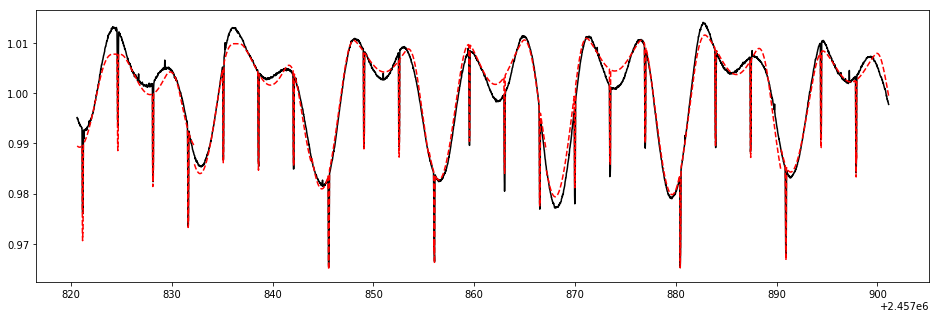

In [9]:
fig, ax = plt.subplots(figsize=(16, 5))

plt.plot(table['JD'], flux/flux.mean(), color='k')
from glob import glob

times = []
fluxes = []
for path in glob('rotations/rotation?/rot?_lcbest.txt'):
    stsp = Table.read(path, format='ascii.fast_no_header')
    stsp_time = stsp['col1']
    stsp_flux = stsp['col4']
    times.append(stsp_time)
    fluxes.append(stsp_flux)
    plt.plot(stsp_time, stsp_flux/stsp_flux.mean(), color='r', ls='--')
plt.show()

In [16]:
import batman
import sys
sys.path.insert(0, '/Users/bmmorris/git/libra/')
sys.path.insert(0, '/Users/bmmorris/git/gravdark/')
from gravdark import LightCurve, TransitLightCurve
from libra import transit_duration

params = batman.TransitParams()
params.per = 3.4878840
params.t0 = 7824.65336 + 2450000
params.inc = 86.99
params.ecc = 0
params.w = 90
params.a = 9.43

q1 = 0.29
q2 = 0.48
u1 = 2*np.sqrt(q1)*q2
u2 = np.sqrt(q1)*(1 - 2*q2)
params.u = [u1, u2]
params.rp = 0.1305
params.limb_dark = 'quadratic'
duration = transit_duration(params)
params.duration = duration

In [17]:
times = np.hstack(times)
fluxes = np.hstack(fluxes)

lc = LightCurve(table["JD"], flux)
transits = LightCurve(**lc.mask_out_of_transit(params, oot_duration_fraction=2)).get_transit_light_curves(params)

model_lc = LightCurve(times, fluxes)
model_transits = LightCurve(**model_lc.mask_out_of_transit(params, oot_duration_fraction=2)).get_transit_light_curves(params)

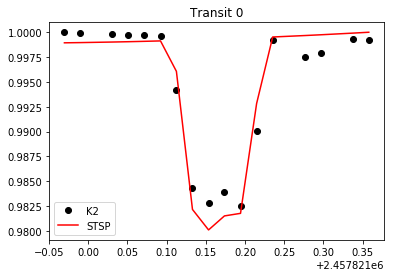

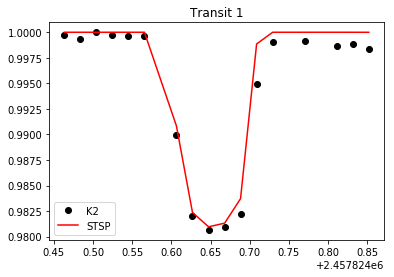

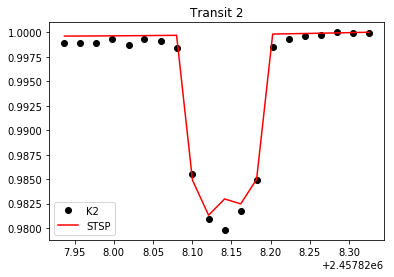

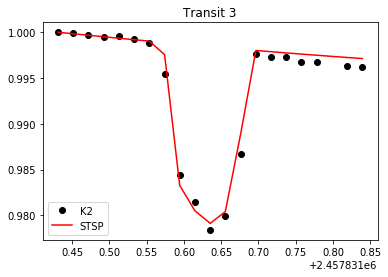

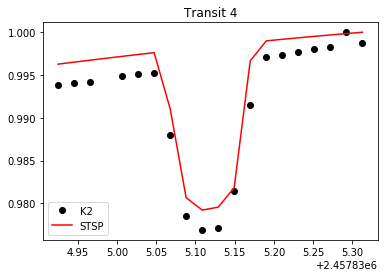

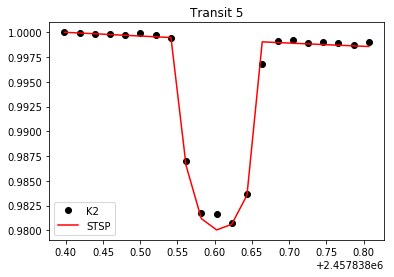

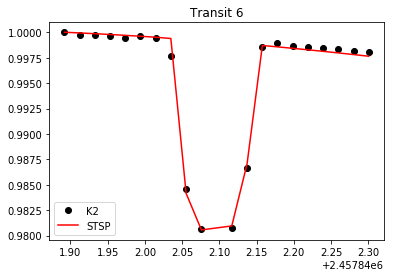

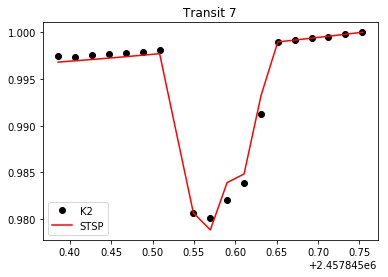

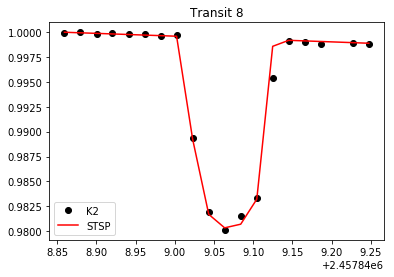

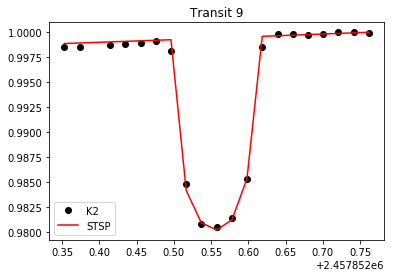

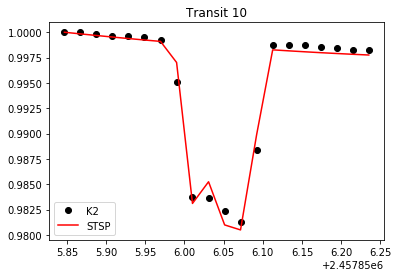

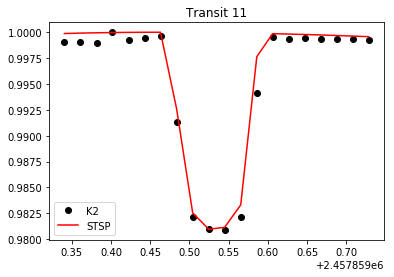

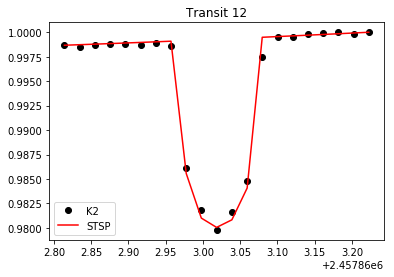

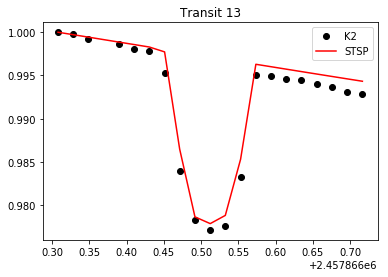

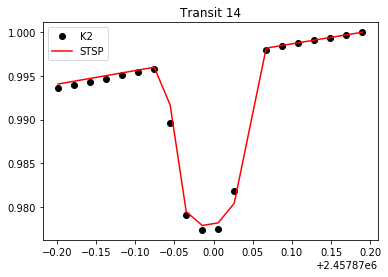

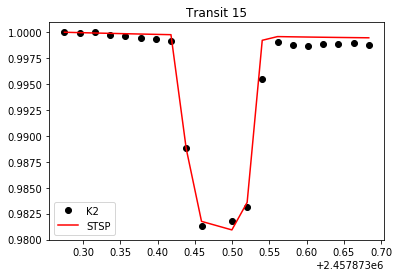

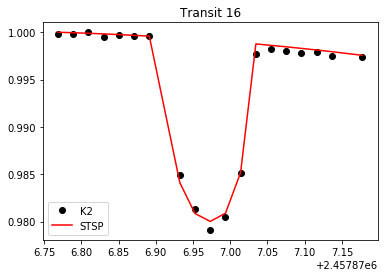

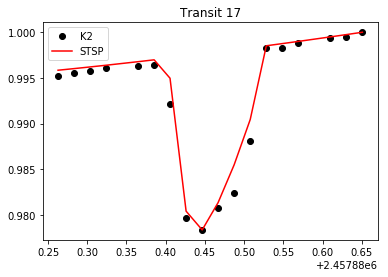

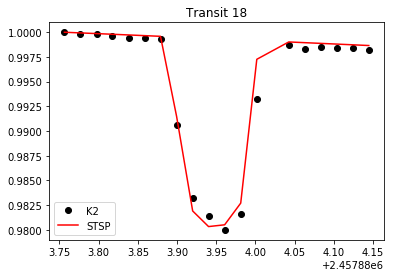

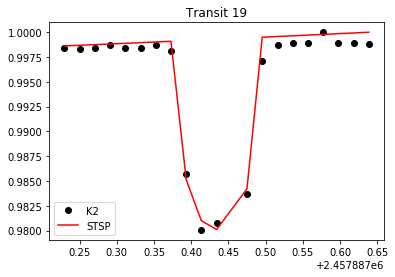

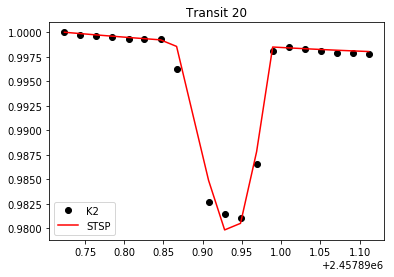

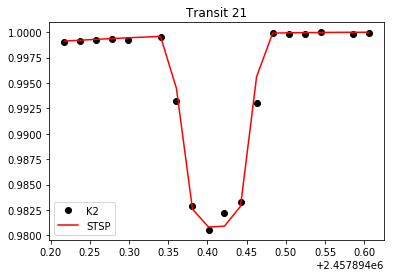

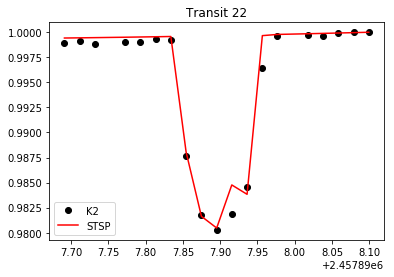

In [18]:
for i, transit, model in zip(range(len(transits)), transits, model_transits):
    plt.title('Transit {0}'.format(i))
    plt.plot(transit.times.jd, transit.fluxes/transit.fluxes.max(), 'ko', label='K2')
    plt.plot(model.times.jd, model.fluxes/model.fluxes.max(), color='r', label='STSP')
    plt.legend()
    plt.show()